<a href="https://colab.research.google.com/github/benihime91/Covid-Waste-Detection/blob/main/02-detectron2-model-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Covid 19 Waste Detection using Detectron 2
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

# Install detectron2

In [3]:
# install dependencies: 
!pip install -Uqq pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

     |████████████████████████████████| 276kB 8.0MB/s 
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
import torch
assert torch.__version__.startswith("1.8")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html -Uqq

     |████████████████████████████████| 6.2MB 1.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 


In [5]:
# What GPU are we using?
!nvidia-smi

Mon May  3 12:12:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Dependencies

In [6]:
import copy
import glob
import os
import random
import time
import logging

# import some common libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# import some common detectron2 utilities
import detectron2
import detectron2.data.transforms as T
from detectron2 import model_zoo
from detectron2.config import CfgNode, get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data import detection_utils as utils
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.engine.defaults import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.collect_env import collect_env_info
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer

In [7]:
# Some basic setup:

# Setup detectron2 logger
setup_logger()

# Setup logger
logger = logging.getLogger("detectron2")

# Function to save the Training config
def save_config(cfg):
    path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    if isinstance(cfg, CfgNode):
        with PathManager.open(path, "w") as f:
            f.write(cfg.dump())
    else:
        logger.info("❌ Could not save cfg")
    logger.info("🔎 Full config saved to {}".format(path))

# Import and Register Custom Detectron2 Data


## Prepare the dataset

Unzip the dataset saved in google drive ...

In [8]:
!unzip /content/drive/MyDrive/waste.zip -d /content/ > /dev/null

Our dataset, considers the classes of the these following categories to detect -
* Face Mask
* Syringe
* Glove

The Images were collected from Google Images as well as some self collected ones. Image annotations were done using  [labelImg](https://github.com/tzutalin/labelImg).

Our dataset is divided into the common training, validation and test splits. These splits contain 297, 31, 30 images respectively.



## Register dataset
Before I can train a model I've got to register a dataset in Detectron2 style: https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset

In [9]:
register_coco_instances(
    "my_dataset_train",
    {},
    "/content/waste/train/_annotations.coco.json",
    "/content/waste/train",
)
register_coco_instances(
    "my_dataset_val",
    {},
    "/content/waste/valid/_annotations.coco.json",
    "/content/waste/valid",
)
register_coco_instances(
    "my_dataset_test",
    {},
    "/content/waste/test/_annotations.coco.json",
    "/content/waste/test",
)

In [10]:
# Training data
dataset_dicts_train= DatasetCatalog.get("my_dataset_train")
# Validation Data
dataset_dicts_val  = DatasetCatalog.get("my_dataset_val")
# Test Data
dataset_dicts_test = DatasetCatalog.get("my_dataset_test")

WARNING [05/03 12:13:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 12:13:33 d2.data.datasets.coco]: Loaded 297 images in COCO format from /content/waste/train/_annotations.coco.json
WARNING [05/03 12:13:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 12:13:33 d2.data.datasets.coco]: Loaded 31 images in COCO format from /content/waste/valid/_annotations.coco.json
WARNING [05/03 12:13:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 12:13:33 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/waste/test/_annotations.coco.json


In [11]:
#Training data
metadata = MetadataCatalog.get("my_dataset_train")
metadata

Metadata(evaluator_type='coco', image_root='/content/waste/train', json_file='/content/waste/train/_annotations.coco.json', name='my_dataset_train', thing_classes=['covid-19-waste', 'glove', 'mask', 'syringe'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3})

## Visualize dataset
To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

In [12]:
def visualize_sample(data_dicts, metadata, n=1):
  """
  Show n random samples from data_dicts, label with metadata.
  """
  for d in random.sample(data_dicts, n):
    logger.info(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(10, 6))
    plt.imshow(vis.get_image())
    plt.xticks([])
    plt.yticks([])
    plt.show()

[05/03 12:13:41 detectron2]: {'file_name': '/content/waste/train/TUFZMTIxODUxNjMy_jpg.rf.d9ff4f0f37deb3a3dc0ab1671f1b3974.jpg', 'height': 512, 'width': 512, 'image_id': 36, 'annotations': [{'iscrowd': 0, 'bbox': [257, 202, 109, 195.5], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


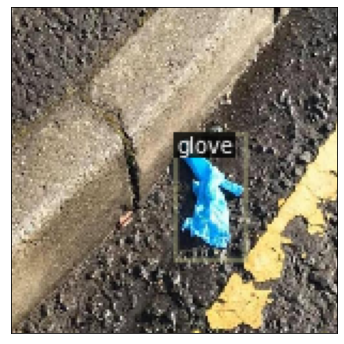

[05/03 12:13:41 detectron2]: {'file_name': '/content/waste/train/Syringes-burnham-beach_jpg.rf.ceb2f2367e293ecd6380b235d98d8356.jpg', 'height': 512, 'width': 512, 'image_id': 15, 'annotations': [{'iscrowd': 0, 'bbox': [99, 176, 218, 198], 'category_id': 3, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [204, 194, 234, 202], 'category_id': 3, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


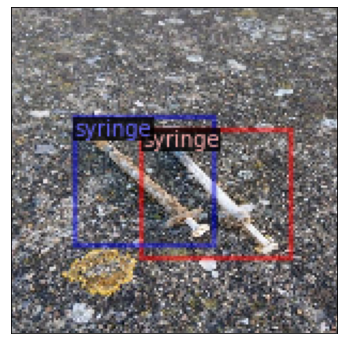

[05/03 12:13:41 detectron2]: {'file_name': '/content/waste/train/JS70381725_jpg.rf.41a1b3b2da1ca1db0e9cffc99b726476.jpg', 'height': 512, 'width': 512, 'image_id': 134, 'annotations': [{'iscrowd': 0, 'bbox': [48, 71, 124.5, 286], 'category_id': 3, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [217, 127, 224.5, 200], 'category_id': 3, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


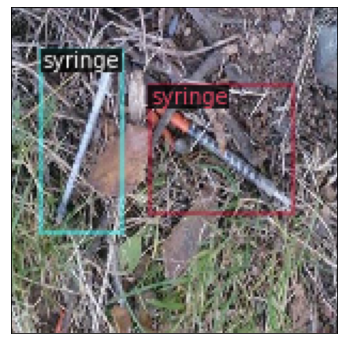

[05/03 12:13:41 detectron2]: {'file_name': '/content/waste/train/IMG20210427120509_jpg.rf.a8b85befa9d57be40b0d63e0eb733143.jpg', 'height': 512, 'width': 512, 'image_id': 245, 'annotations': [{'iscrowd': 0, 'bbox': [59, 185, 359.5, 218.5], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


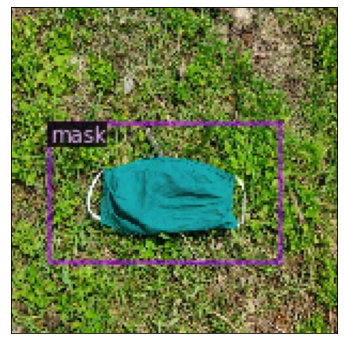

In [13]:
visualize_sample(dataset_dicts_train, metadata, n=4)

# Train!

The following code is original training code from the Detectron2 example notebook but I think we can make it better/suit our problem.

In [14]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

    @classmethod
    def build_model(cls, cfg):
        """
        Returns:
            torch.nn.Module:
        It now calls :func:`detectron2.modeling.build_model`.
        Overwrite it if you'd like a different model.
        """
        model = build_model(cfg)
        return model

Now, let's fine-tune a COCO-pretrained [RetinaNet](https://openaccess.thecvf.com/content_ICCV_2017/papers/Lin_Focal_Loss_for_ICCV_2017_paper.pdf) model on the balloon dataset.

In [15]:
cfg = get_cfg()

# Base config for RETINANET
cfg.merge_from_file(model_zoo.get_config_file("Base-RetinaNet.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val", )
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = len(metadata.thing_classes)

cfg.SOLVER.NESTEROV = True
cfg.SOLVER.IMS_PER_BATCH = 2 # No of Images per Batch
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.BASE_LR = 1e-03 # base learning rate for training
cfg.SOLVER.MAX_ITER = 8000 # how many iterations to train for
cfg.SOLVER.WARMUP_ITERS = 1000 # how many iterations does it take to warmup to the learning rate

# how often to evaluate the data (number of steps, usual is to do at the end of all training)
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER 

cfg.OUTPUT_DIR = f"drive/MyDrive/detectron2-outputs/{str(time.time()).split('.')[0]}"

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


**Data Augmentation** - To apply data augmentation to Images we need to write to custom dataset mapper function

In [18]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [19]:
# full training config
# print(cfg.dump())

## Run Training Loop

In [20]:
if __name__ == "__main__":
    logger.info("🚀 BEGIN TRAINING :")
    logger.info(f"🏃‍♂️ TRAINING FOR {cfg.SOLVER.MAX_ITER} ITERATIONS\n")
    logger.info(f"📕 TRAINING LOGS SAVED IN {cfg.OUTPUT_DIR}")
    save_config(cfg)

    print(f"---------"*20)

    trainer = CustomTrainer(cfg)

    trainer.resume_or_load(resume=False)
    trainer.train()

[05/03 12:14:38 detectron2]: 🚀 BEGIN TRAINING :
[05/03 12:14:38 detectron2]: 🏃‍♂️ TRAINING FOR 8000 ITERATIONS

[05/03 12:14:38 detectron2]: 📕 TRAINING LOGS SAVED IN drive/MyDrive/detectron2-outputs/1620044056
[05/03 12:14:38 detectron2]: 🔎 Full config saved to drive/MyDrive/detectron2-outputs/1620044056/config.yaml
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WARNING [05/03 12:14:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 12:14:44 d2.data.datasets.coco]: Loaded 297 images in COCO format from /content/waste/train/_annotations.coco.json
[05/03 12:14:44 d2.data.build]: Removed 0 images with no usable annotations. 297 images left.
[05/03 12:14:44 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |  category  | #instances   |  cat

model_final_5bd44e.pkl: 152MB [00:03, 48.7MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (36, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.


[05/03 12:14:49 d2.engine.train_loop]: Starting training from iteration 0
[05/03 12:15:02 d2.utils.events]:  eta: 1:28:33  iter: 19  total_loss: 1.715  loss_cls: 1.243  loss_box_reg: 0.4553  time: 0.6634  data_time: 0.0172  lr: 1.9258e-05  max_mem: 873M
[05/03 12:15:05 d2.utils.events]:  eta: 1:14:42  iter: 39  total_loss: 1.53  loss_cls: 0.9832  loss_box_reg: 0.5207  time: 0.4045  data_time: 0.0057  lr: 3.8477e-05  max_mem: 873M
[05/03 12:15:08 d2.utils.events]:  eta: 0:17:42  iter: 59  total_loss: 1.724  loss_cls: 1.234  loss_box_reg: 0.5291  time: 0.3095  data_time: 0.0057  lr: 5.7695e-05  max_mem: 873M
[05/03 12:15:10 d2.utils.events]:  eta: 0:17:04  iter: 79  total_loss: 1.064  loss_cls: 0.7082  loss_box_reg: 0.356  time: 0.2620  data_time: 0.0053  lr: 7.6914e-05  max_mem: 873M
[05/03 12:15:13 d2.utils.events]:  eta: 0:16:46  iter: 99  total_loss: 1.008  loss_cls: 0.7063  loss_box_reg: 0.3193  time: 0.2339  data_time: 0.0051  lr: 9.6133e-05  max_mem: 873M
[05/03 12:15:15 d2.utils.

In [ ]:
# Look at training curves in tensorboard in Google Colab:
%reload_ext tensorboard
%tensorboard --logdir {cfg.OUTPUT_DIR}

Upload tensorboad data to `tensorboard_dev`. Uploading the TensorBoard logs will give you a URL that can be shared with anyone

In [21]:
!tensorboard dev upload --logdir {cfg.OUTPUT_DIR} \
  --name "Covid 19 Waste Detectron2" \
  --description "Initial Training Results (ver-0.0.3)" \
  --one_shot

2021-05-03 12:34:18.144657: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

drive/MyDrive/detectron2-outputs/1620044056

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn

# Inference & evaluation using the trained model

Now, let's run inference with the trained model on our test dataset.
First, let's create a predictor using the model we just trained:

In [22]:
%ls -l {cfg.OUTPUT_DIR}

total 567453
-rw------- 1 root root      5939 May  3 12:14 config.yaml
-rw------- 1 root root    154194 May  3 12:31 events.out.tfevents.1620044085.fc47e37e0874.61.0
-rw------- 1 root root        15 May  3 12:31 last_checkpoint
-rw------- 1 root root    112191 May  3 12:31 metrics.json
-rw------- 1 root root 290398255 May  3 12:25 model_0004999.pth
-rw------- 1 root root 290398255 May  3 12:31 model_final.pth


In [23]:
OUTPUT_DIR = cfg.OUTPUT_DIR

#test evaluation
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg = get_cfg()
cfg.merge_from_file(f'{OUTPUT_DIR}/config.yaml')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # path to the model we just trained
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.50 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

## COCO Api Inference on Test Dataset

In [24]:
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [05/03 12:36:04 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [05/03 12:36:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 12:36:04 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/waste/test/_annotations.coco.json
[05/03 12:36:04 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| covid-19-wa.. | 0            |   glove    | 16           |    mask    | 26           |
|    syringe    | 6            |            |              |            |              |
|     total     | 48           |            |              |            |              |
[05/03 12:36:04 d2.data.dataset_mapper]: [Dat

OrderedDict([('bbox',
              {'AP': 33.30913052280606,
               'AP-covid-19-waste': nan,
               'AP-glove': 36.335303357922,
               'AP-mask': 29.146543656040723,
               'AP-syringe': 34.445544554455445,
               'AP50': 73.91529611832904,
               'AP75': 20.163330058496047,
               'APl': 36.860005755519886,
               'APm': 15.0,
               'APs': nan})])

## Inference with Detectron2 Saved Weights

 We randomly select several samples to visualize the prediction results.

In [25]:
%ls {cfg.OUTPUT_DIR}

coco_instances_results.json                       last_checkpoint
config.yaml                                       metrics.json
events.out.tfevents.1620044085.fc47e37e0874.61.0  model_0004999.pth
instances_predictions.pth                         model_final.pth


### Create inference function
Function should take in config file, model weights, thresholds and number of predictions to make per image.

In [26]:
def make_inference(image, model_config, model_weights, threshold=0.5, n=5, save=False):
  """
  Makes inference on image (single image) using model_config, model_weights and threshold.

  Returns image with n instance predictions drawn on.

  Params:
  -------
  image (str) : file path to target image
  model_config (str) : file path to model config in .yaml format
  model_weights (str) : file path to model weights 
  threshold (float) : confidence threshold for model prediction, default 0.5
  n (int) : number of prediction instances to draw on, default 5
    Note: some images may not have 5 instances to draw on depending on threshold,
    n=5 means the top 5 instances above the threshold will be drawn on.
  save (bool) : if True will save image with predicted instances to file, default False
  """

  cfg = get_cfg()
  cfg.merge_from_file(model_config)
  cfg.MODEL.WEIGHTS = model_weights
  cfg.MODEL.RETINANET.SCORE_THRESH_TEST = threshold

  # Setup predictor
  predictor = DefaultPredictor(cfg)
  img = cv2.imread(image)
  visualizer = Visualizer(img_rgb=img[:, :, ::-1],
                          metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]),
                          scale=0.7)
  
  outputs = predictor(img) # Outputs: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.Instances
  # Get instance predictions from outputs
  instances = outputs["instances"]
  # Draw on predictions to image
  vis = visualizer.draw_instance_predictions(instances[:n].to("cpu"))

  # Plot the figure (display the image)
  plt.figure(figsize=(10, 10))
  plt.imshow(vis.get_image())
  plt.xticks([])
  plt.yticks([])
  # TODO: Fix saving
  #if save: plt.savefig("custom_preds/pred_"+d)
  plt.show()

Get the test Images-

In [27]:
test_img_dicts = DatasetCatalog.get('my_dataset_test')

WARNING [05/03 12:36:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 12:36:21 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/waste/test/_annotations.coco.json


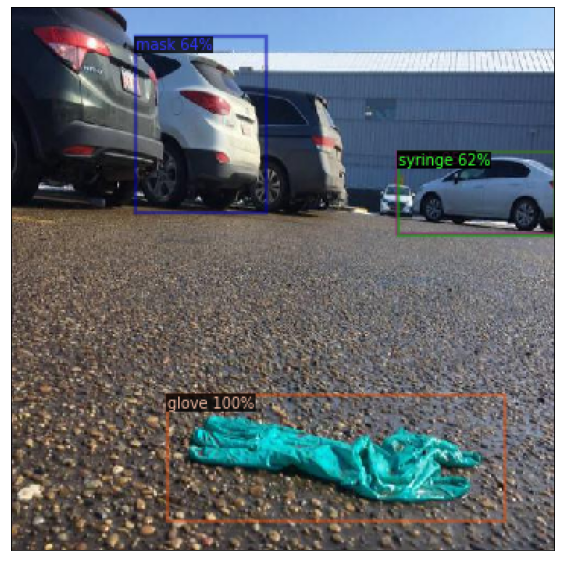

In [28]:
for d in random.sample(test_img_dicts, 1):
  img = d["file_name"]
  make_inference(image=img, n=10, threshold=0.5,
                 model_config=os.path.join(cfg.OUTPUT_DIR, "config.yaml"), 
                 model_weights=os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))

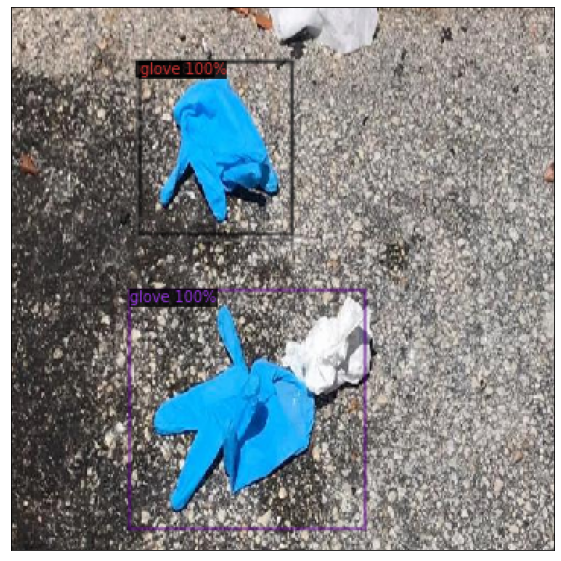

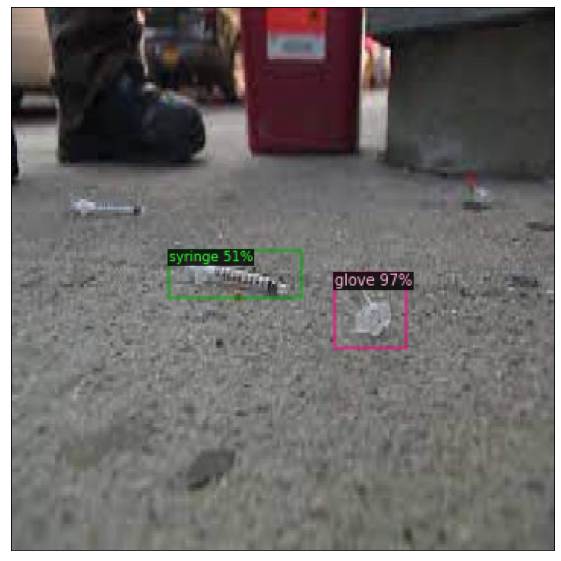

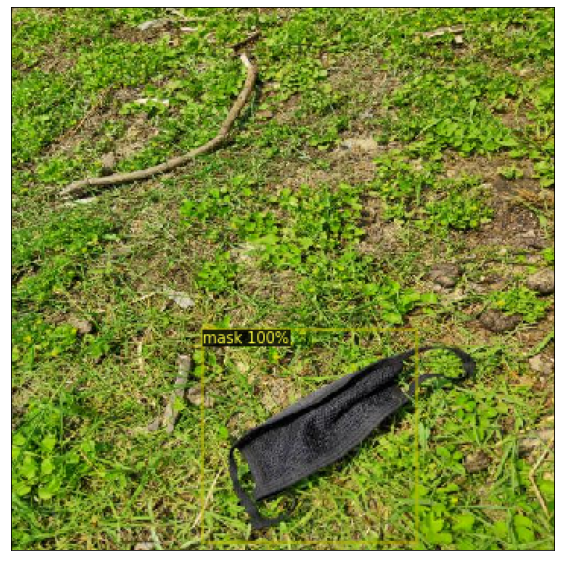

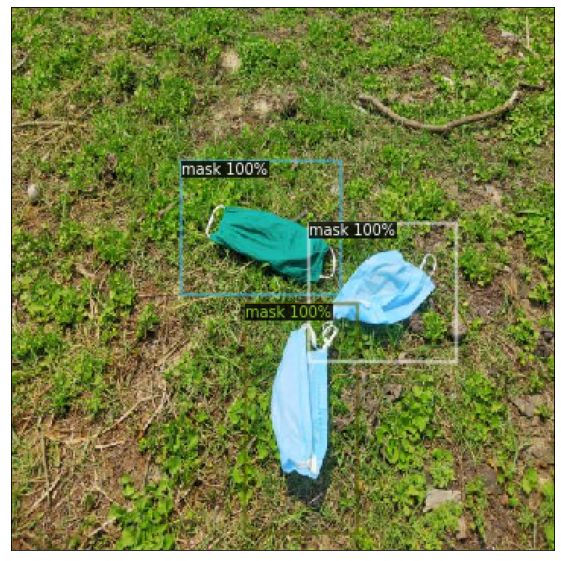

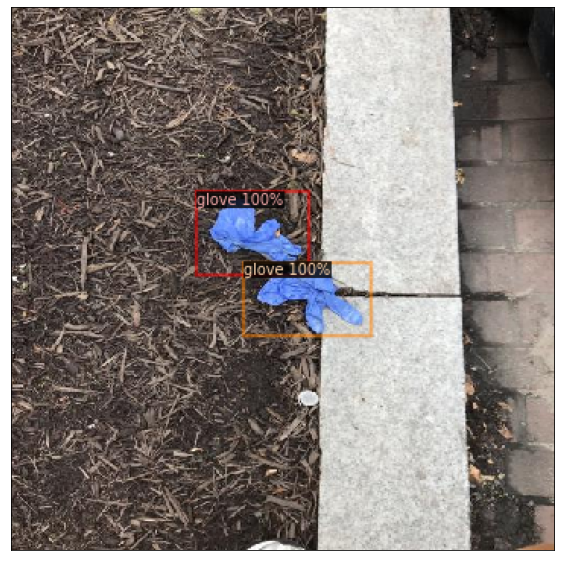

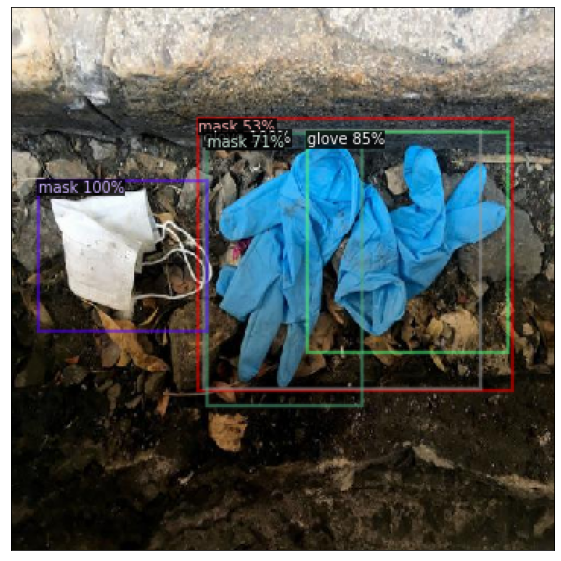

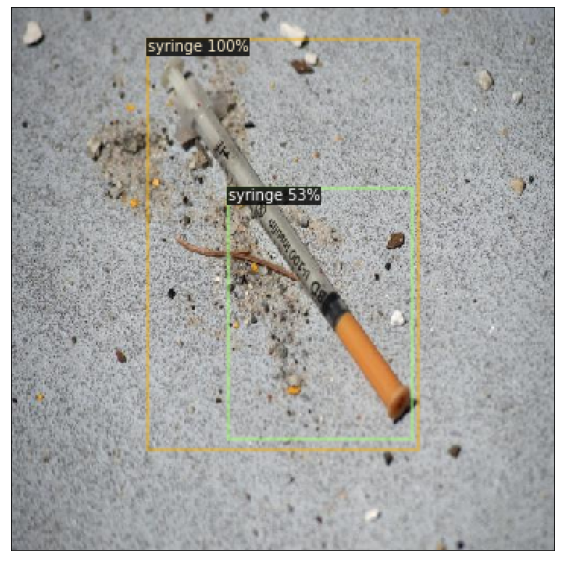

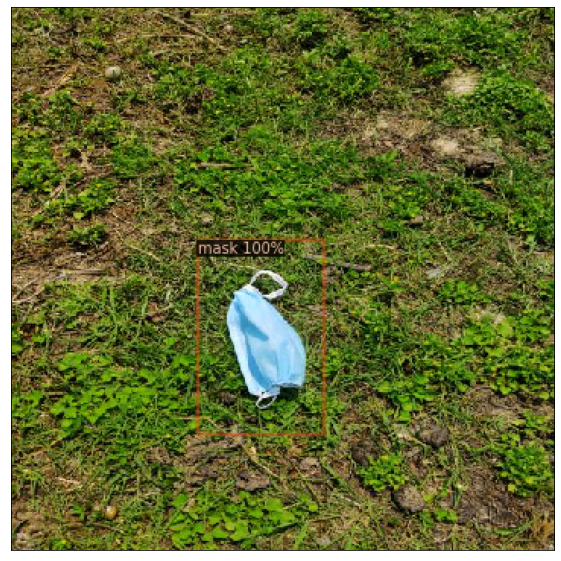

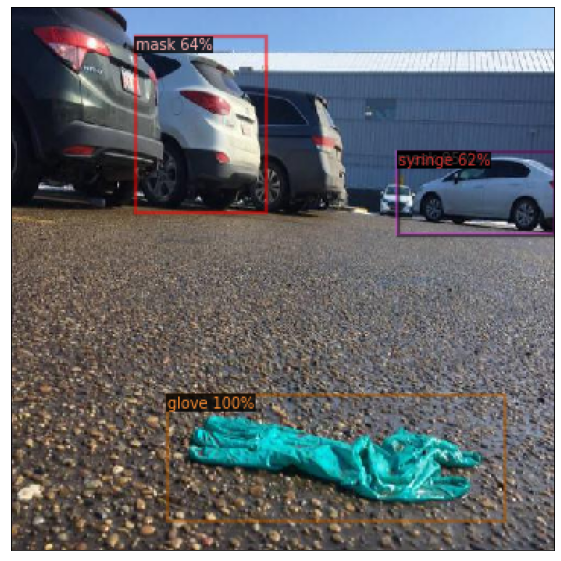

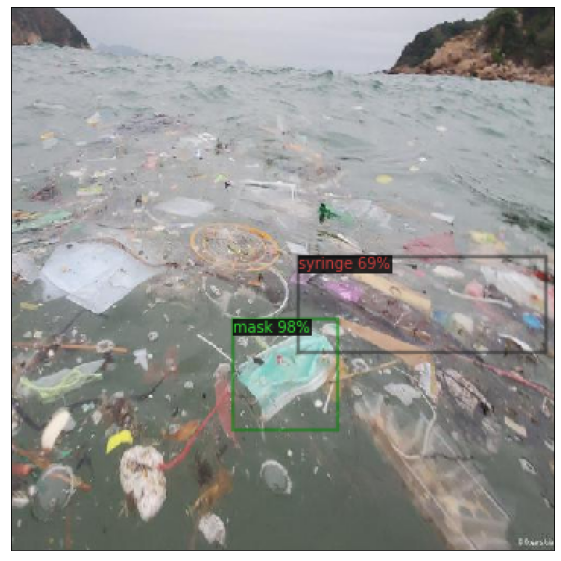

In [29]:
for d in random.sample(test_img_dicts, 10):
  img = d["file_name"]
  make_inference(image=img, n=10, threshold=0.5,
                 model_config=os.path.join(cfg.OUTPUT_DIR, "config.yaml"), 
                 model_weights=os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))